In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

In [10]:
df = pd.read_csv('ice_cream.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [11]:
df.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [12]:
df['date'] = pd.to_datetime(df.date)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [13]:
df.set_index('date', inplace=True)
df.head()

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [14]:
start_date = pd.to_datetime('2010-01-01')
df = df[start_date:]
df.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


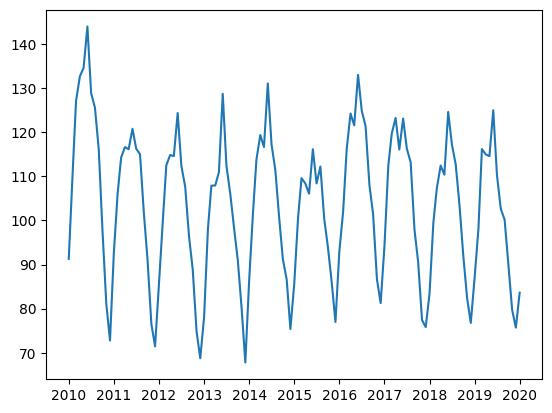

In [15]:
plt.plot(df.production)
plt.show()

# ACF

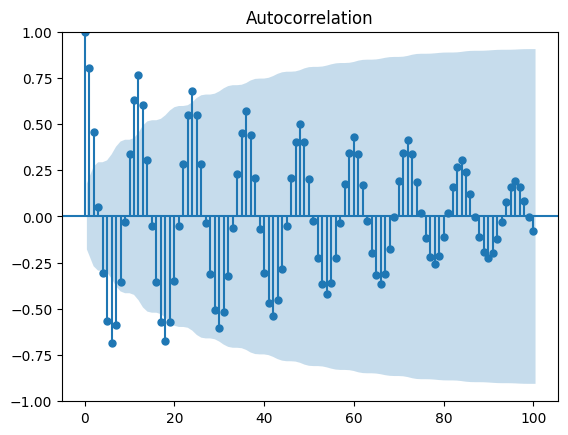

In [16]:
acf_plot = plot_acf(df.production, lags=100)

#### Based on decaying PCF we are likely dealing with Auto Regressive model

# PACF

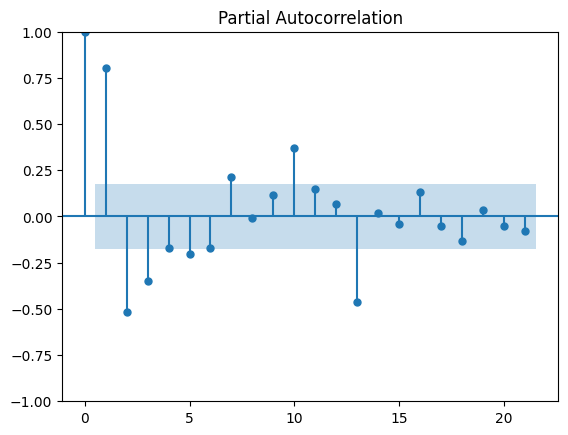

In [17]:
pacf_plot = plot_pacf(df.production)

#### Based on PACF, we can start an auto-regressive model based on 1,2,3,10 and 13

# Stock Data

In [18]:
# Getting stocks data
import yfinance as yf
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2015-1-1', end='2020-1-1')
tickerDf = tickerDf[['Close']]
tickerDf.head()

/media/crsdvaibhav/New Volume/notes/finance/time-series/env/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
Date,
2015-01-02 00:00:00-05:00,174.806793
2015-01-05 00:00:00-05:00,171.649811
2015-01-06 00:00:00-05:00,170.033066
2015-01-07 00:00:00-05:00,172.151886
2015-01-08 00:00:00-05:00,175.206741


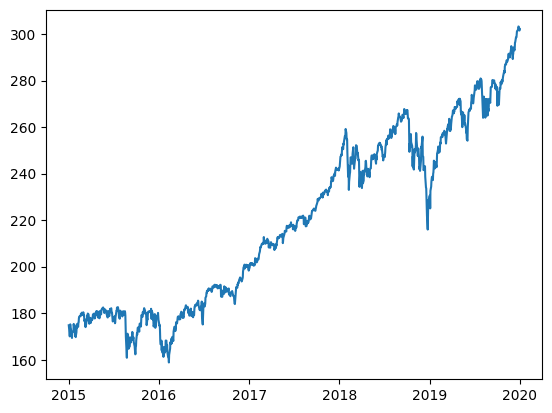

In [19]:
plt.plot(tickerDf.Close)
plt.show()

#### This is not stationary and is increasing, so we can plot first difference of this series, which is the price on this day minus the stock price on the previous day

In [20]:
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])
tickerDf['FirstDifference'] = first_diffs
tickerDf.head()

,Close,FirstDifference
Date,,
2015-01-02 00:00:00-05:00,174.806793,-3.156982
2015-01-05 00:00:00-05:00,171.649811,-1.616745
2015-01-06 00:00:00-05:00,170.033066,2.118820
2015-01-07 00:00:00-05:00,172.151886,3.054855
2015-01-08 00:00:00-05:00,175.206741,-1.404037


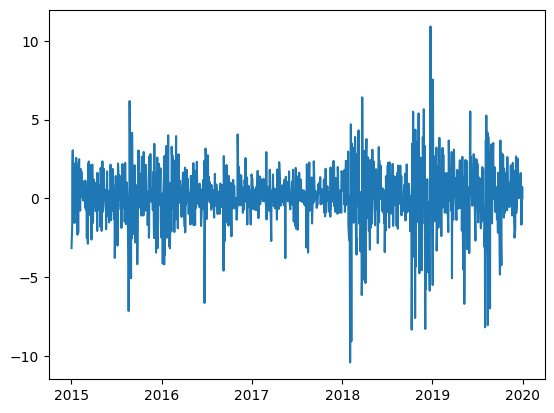

In [21]:
plt.plot(tickerDf.FirstDifference)
plt.show()

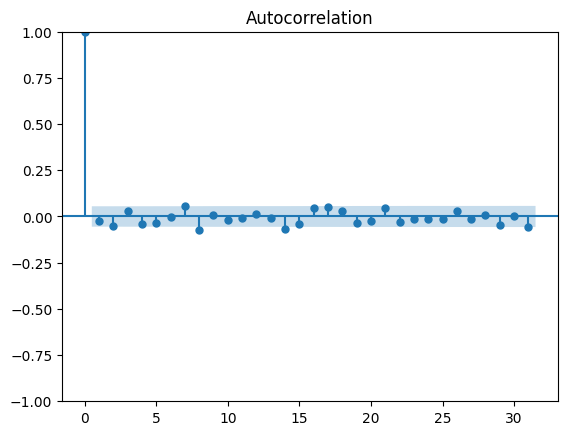

In [22]:
acf_plot = plot_acf(tickerDf.FirstDifference)

#### ACF is not helpful

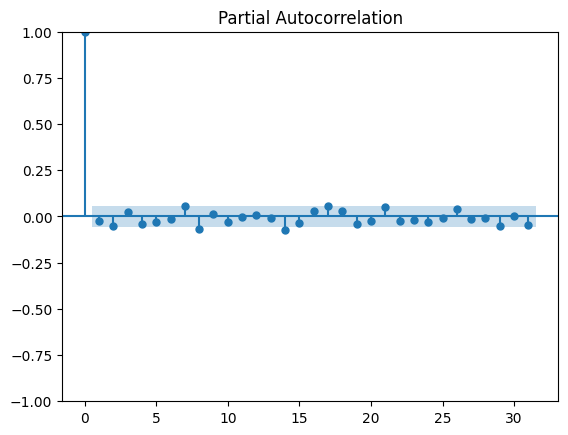

In [23]:
pacf_plot = plot_pacf(tickerDf.FirstDifference)

#### This is also not that much helpful, which tells that stock price prediction is not an easy process

# Augmented Dickey Fuller Test

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def generate_ar_process(lags, coefs, length):
    
    #cast coefs to np array
    coefs = np.array(coefs)
    
    #initial values
    series = [np.random.normal() for _ in range(lags)]
    
    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]
        
        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()
        
        series.append(new_val)
        
    return np.array(series)

In [26]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF statistic : %f' % result[0])
    print('p-value : %f' % result[1])

# AR(1) Process

#### Stationary

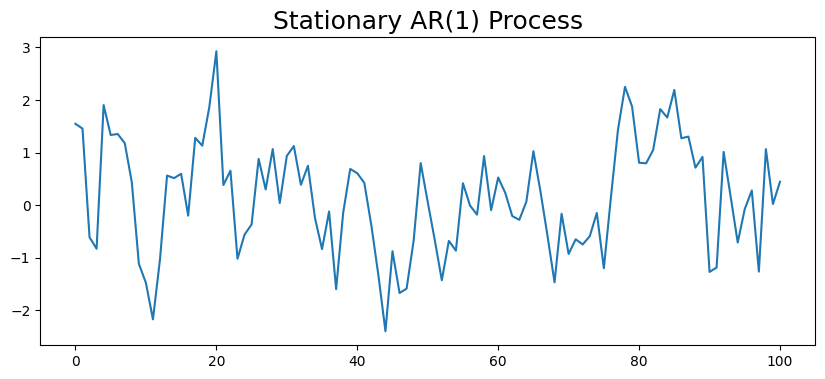

In [27]:
ar_1_process = generate_ar_process(1, [.5], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process)
plt.title('Stationary AR(1) Process', fontsize=18)
plt.show()

In [28]:
perform_adf_test(ar_1_process)

ADF statistic : -5.314843
p-value : 0.000005


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(1) Process')

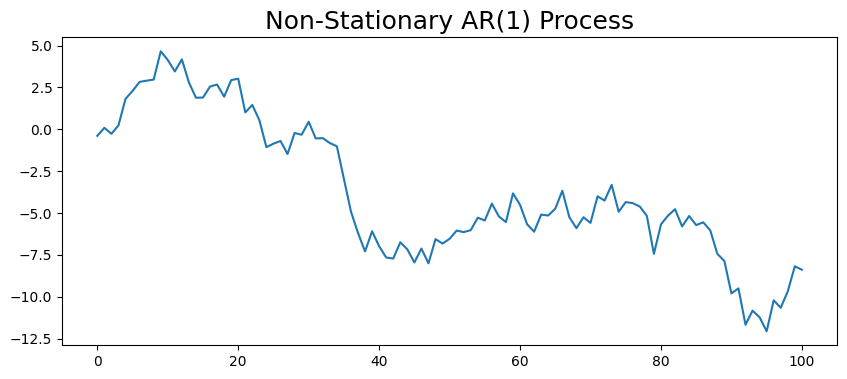

In [29]:
ar_1_process_unit_root = generate_ar_process(1, [1], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process_unit_root)
plt.title('Non-Stationary AR(1) Process', fontsize=18)

In [30]:
perform_adf_test(ar_1_process_unit_root)

ADF statistic : -1.022244
p-value : 0.745065


# AR(2) Process

#### Stationary

Text(0.5, 1.0, 'Stationary AR(2) Process')

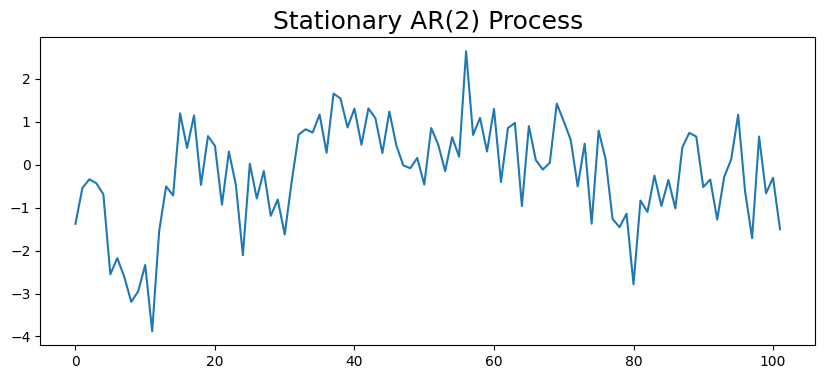

In [31]:
ar_2_process = generate_ar_process(2, [.5, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process)
plt.title('Stationary AR(2) Process', fontsize=18)

In [32]:
perform_adf_test(ar_2_process)

ADF statistic : -3.055354
p-value : 0.030039


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(2) Process')

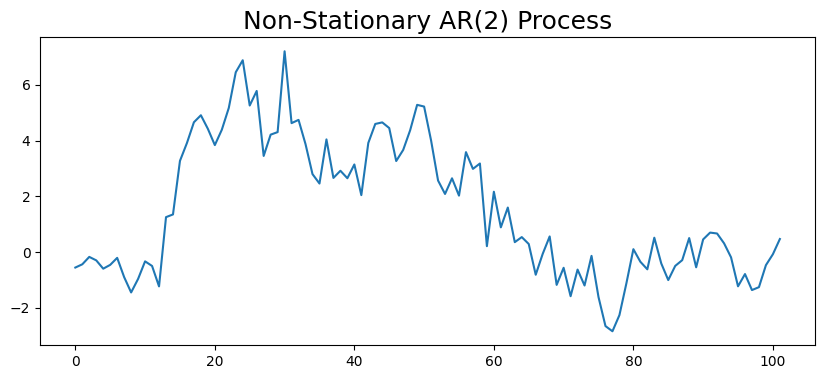

In [33]:
ar_2_process_unit_root = generate_ar_process(2, [.7, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process_unit_root)
plt.title('Non-Stationary AR(2) Process', fontsize=18)

In [34]:
perform_adf_test(ar_2_process_unit_root)

ADF statistic : -1.895774
p-value : 0.334052


# AR Model

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from time import time
from datetime import datetime
from datetime import timedelta

In [36]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [37]:
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser)
production_ice_cream.squeeze('columns')

/tmp/ipykernel_35214/2938833982.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser)


DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: IPN31152N, Length: 577, dtype: float64

In [38]:
production_ice_cream.rename(columns = {'IPN31152N':'production'}, inplace=True)
production_ice_cream.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [39]:
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [40]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

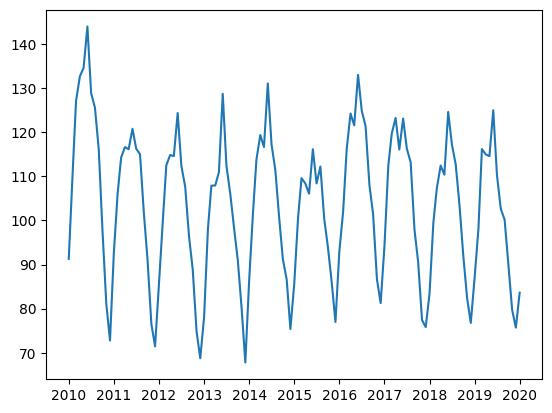

In [41]:
plt.plot(production_ice_cream)
plt.show()

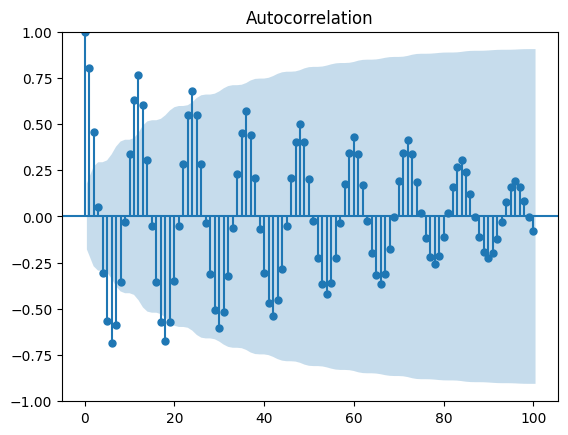

In [42]:
acf_plot = plot_acf(production_ice_cream, lags=100)

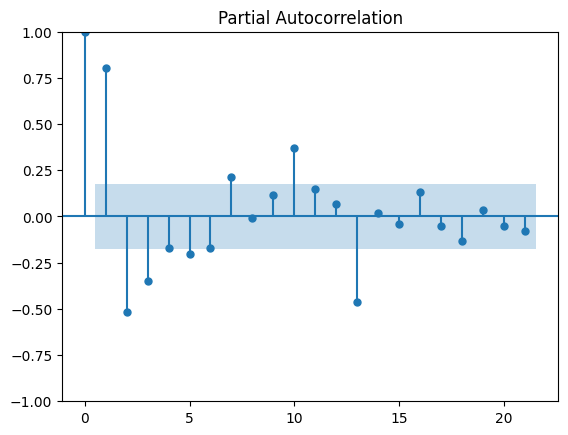

In [43]:
pacf_plot = plot_pacf(production_ice_cream)

#### We start with AR(3), with lags 1,2,3

In [44]:
# Training and test sets

train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [45]:
# Fit the AR model

model = ARIMA(train_data, order=(13,0,0))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting time: ", end-start)

Model fitting time:  1.689976692199707


/media/crsdvaibhav/New Volume/notes/finance/time-series/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                ARIMA(13, 0, 0)   Log Likelihood                -309.151
Date:                Thu, 15 Feb 2024   AIC                            648.303
Time:                        20:38:50   BIC                            688.535
Sample:                    01-01-2010   HQIC                           664.615
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.9878      1.634     63.658      0.000     100.786     107.189
ar.L1          0.8838      0.080     11.048      0.000       0.727       1.041
ar.L2          0.0283      0.115      0.245      0.8

#### The P>|Z| tells the P Values and those above 0.5 can be neglected 

In [47]:
# predictions

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.production - predictions


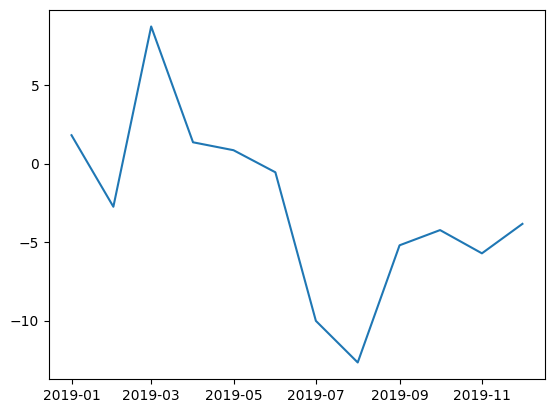

In [48]:
plt.plot(residuals)
plt.show()

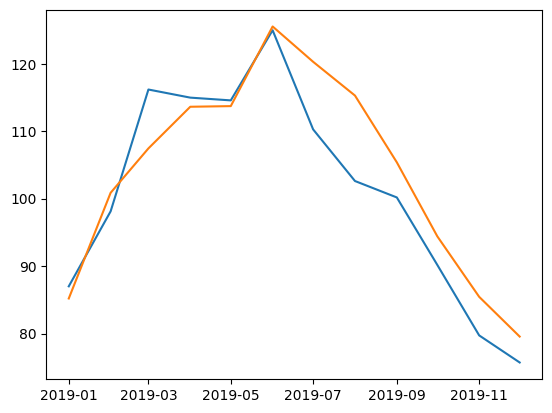

In [49]:
plt.plot(test_data.production)
plt.plot(predictions)
plt.show()

In [50]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data.production)),4))

Mean Absolute Percent Error:  0.0486


In [51]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error:  6.0776407695816355


#### Evaluating a time series:
Generally in time series models, the predictions for a long time ahead are not good as the predictions turn to the global mean. So we do what is called a rolling forecast origin. Lets say we have to predict data for two months ahead, then I can train the model for k-2 months and test on 2 months, then for the next month incorporate the k-1th data and re train the model to predict for k+1th month, and so on.

- Train on 1,2....k-3 -> predict k-2
- Train on 1,2....k-2 -> predict k-1
- Train on 1,2....k-1 -> predict k

and so on, and then average all predictions

In [52]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1) : test_end]

In [53]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

In [54]:
residuals_rolling = test_data.production - predictions_rolling

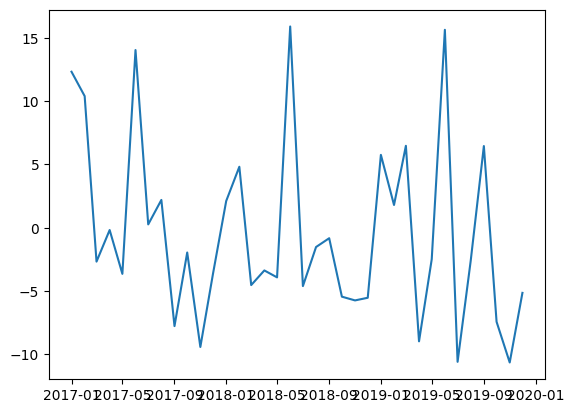

In [55]:
plt.plot(residuals_rolling)
plt.show()

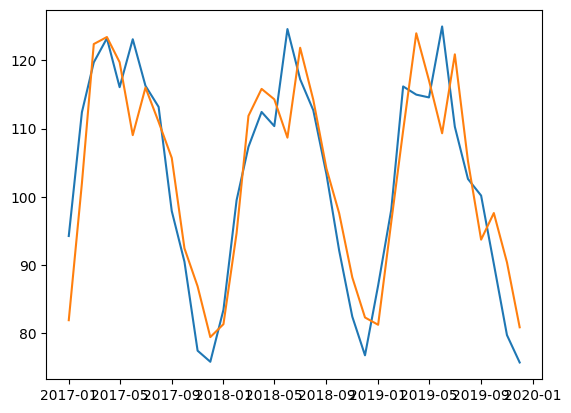

In [56]:
plt.plot(test_data.production)
plt.plot(predictions_rolling)
plt.show()

#### Hence here you can see a much better fit

# Moving Average Model

In [57]:
from statsmodels.tsa.stattools import acf, pacf

In [58]:
# genrating data
errors = np.random.normal(0, 1, 400)
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))

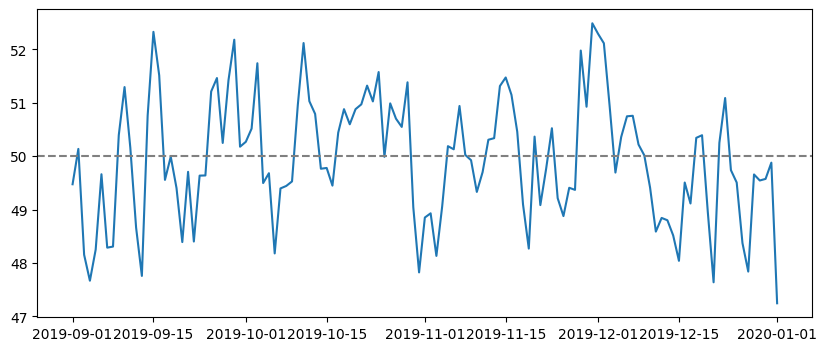

In [59]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

<BarContainer object of 10 artists>

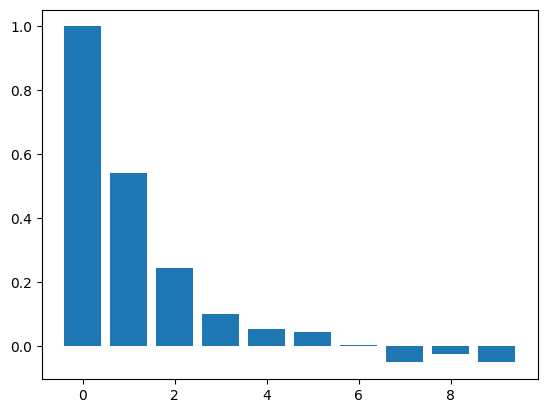

In [60]:
# ACF
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 21 artists>

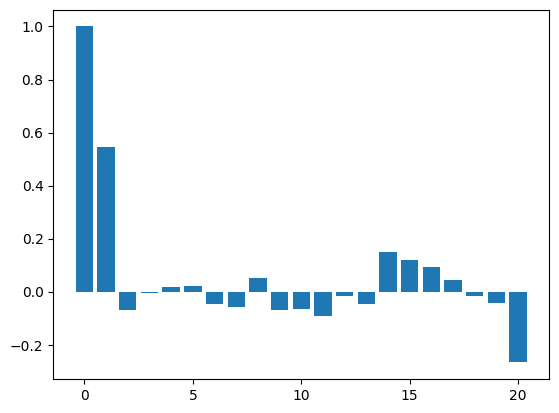

In [61]:
# PACF
pacf_vals = pacf(series)
num_lags = 21
plt.bar(range(num_lags), pacf_vals[:num_lags])

#### As suggested by both ACF and PACF plots we should use MA(2) model

In [62]:
# generate train and test set
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

In [63]:
#create the model
model = ARIMA(train_data, order=(0,0,2))
#fit the model
model_fit = model.fit()
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -164.579
Date:                Thu, 15 Feb 2024   AIC                            337.158
Time:                        20:38:53   BIC                            348.341
Sample:                    09-01-2019   HQIC                           341.700
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9523      0.157    317.683      0.000      49.644      50.260
ma.L1          0.6057      0.085      7.122      0.000       0.439       0.772
ma.L2          0.2306      0.091      2.520      0.0

In [64]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

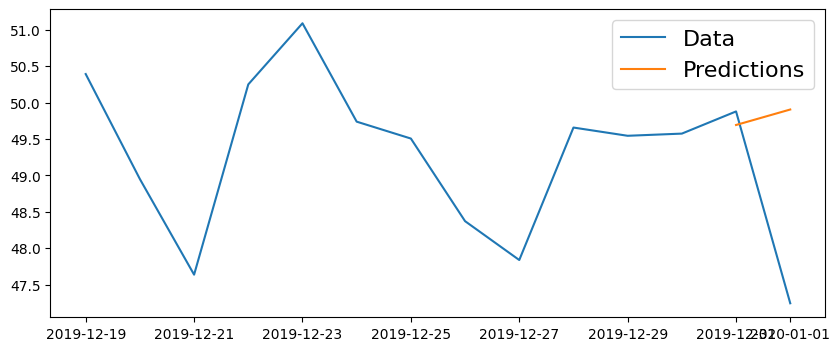

In [65]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [66]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.03
Root Mean Squared Error: 1.88681769831954


# ARMA Model

In [68]:
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
catfish_sales.squeeze('columns')
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

/tmp/ipykernel_35214/3482273373.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [69]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

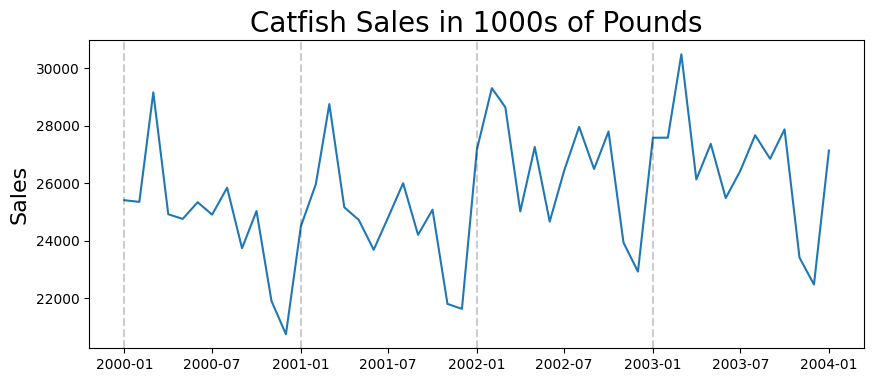

In [84]:

plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [72]:
first_diff = lim_catfish_sales.diff()[1:]

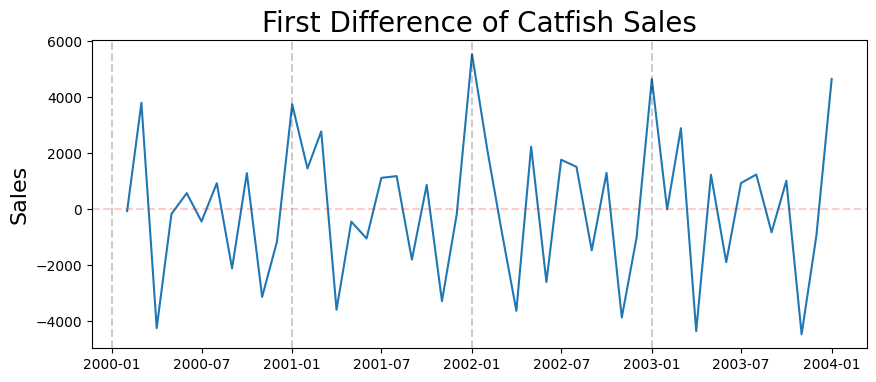

In [74]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.all().mean(), color='r', alpha=0.2, linestyle='--')

<BarContainer object of 17 artists>

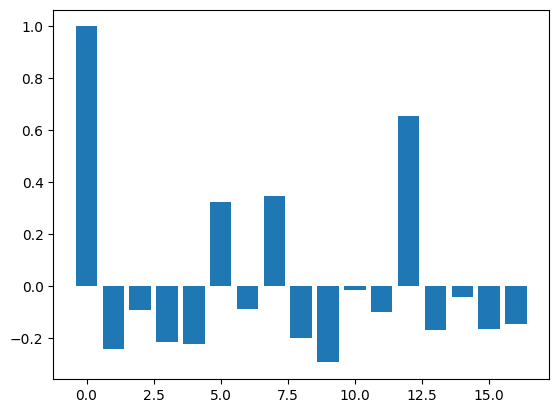

In [86]:
# acf
acf_vals = acf(first_diff)
num_lags=17
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 17 artists>

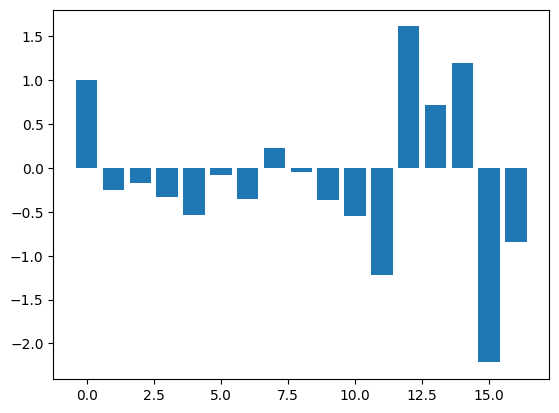

In [87]:
# pacf
pacf_vals = pacf(first_diff)
plt.bar(range(num_lags), pacf_vals[:num_lags])

#### Based on ACF MA(1) and PACF AR(4)

In [88]:
# train and test

train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [89]:
# define model
model = ARIMA(train_data, order=(4,0,1))
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.10715103149414062


In [90]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Thu, 15 Feb 2024   AIC                            767.195
Time:                        20:50:39   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.847
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

In [91]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [98]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.Total - predictions

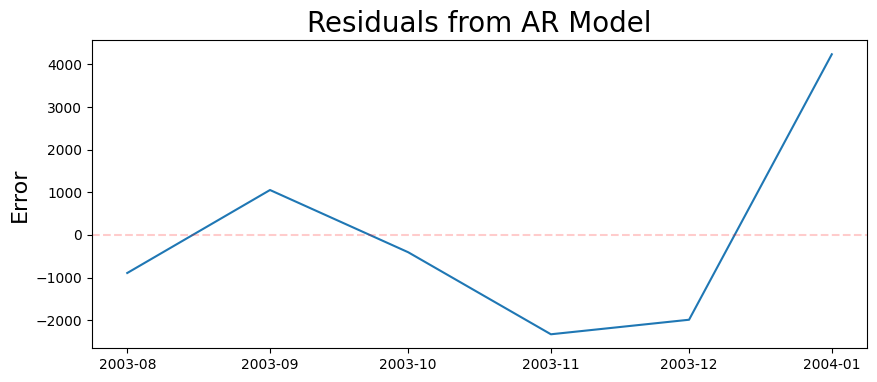

In [99]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

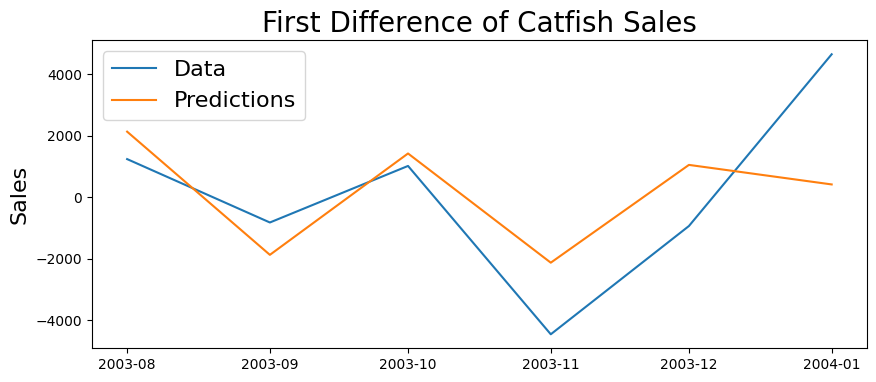

In [100]:
plt.figure(figsize=(10,4))

plt.plot(test_data.Total)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [101]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2214.6996890692794
